In [3]:
library(tidyverse)
library(tidymodels)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

Introduction:
Every day, children and adults around the world suffer from a medical complication known as a stroke. A stroke is when there’s disruption in the blood supply to the brain. Strokes can have serious and potentially life-threatening consequences, as they can lead to brain damage, disability, or even death. There are several factors that contribute to a person’s chances of getting a stroke which include: blood pressure levels, BMI, smoking, physical activity, age, and more. Our project aims to predict the likelihood of someone getting a stroke by examining a person’s blood pressure levels. We want to attempt to answer the following questions: would abnormal blood pressure levels affect your risks of getting a stroke? To what degree, and with how much certainty? How could this risk be minimized or prevented? We will be working with a stroke dataset to help us answer these questions.

In [4]:
stroke <- read_csv("https://raw.githubusercontent.com/Megunight/dsci100-project/main/stroke_prediction_dataset.csv")


Rows: 15000 Columns: 22
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (14): Patient Name, Gender, Marital Status, Work Type, Residence Type, S...
dbl  (8): Patient ID, Age, Hypertension, Heart Disease, Average Glucose Leve...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [14]:
names(stroke) <- c("patient_id", "patient_name", "age", "gender", "hypertension", "heart_disease", "marital_status",
                  "work_type", "residence_type", "average_glucose_level", "bmi", "smoking_status", "alcohol_intake", "physical_activity",
                  "stroke_history", "family_history_of_stroke", "dietary_habits", "stress_levels", "blood_pressure_levels",
                  "cholesterol_levels", "symptoms", "diagnosis")
head(stroke)

patient_id,patient_name,age,gender,hypertension,heart_disease,marital_status,work_type,residence_type,average_glucose_level,⋯,alcohol_intake,physical_activity,stroke_history,family_history_of_stroke,dietary_habits,stress_levels,blood_pressure_levels,cholesterol_levels,symptoms,diagnosis
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,⋯,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
18153,Mamooty Khurana,56,Male,0,1,Married,Self-employed,Rural,130.91,⋯,Social Drinker,Moderate,0,Yes,Vegan,3.48,140/108,"HDL: 68, LDL: 133","Difficulty Speaking, Headache",Stroke
62749,Kaira Subramaniam,80,Male,0,0,Single,Self-employed,Urban,183.73,⋯,Never,Low,0,No,Paleo,1.73,146/91,"HDL: 63, LDL: 70","Loss of Balance, Headache, Dizziness, Confusion",Stroke
32145,Dhanush Balan,26,Male,1,1,Married,Never Worked,Rural,189.00,⋯,Rarely,High,0,Yes,Paleo,7.31,154/97,"HDL: 59, LDL: 95","Seizures, Dizziness",Stroke
6154,Ivana Baral,73,Male,0,0,Married,Never Worked,Urban,185.29,⋯,Frequent Drinker,Moderate,0,No,Paleo,5.35,174/81,"HDL: 70, LDL: 137","Seizures, Blurred Vision, Severe Fatigue, Headache, Confusion",No Stroke
48973,Darshit Jayaraman,51,Male,1,1,Divorced,Self-employed,Urban,177.34,⋯,Rarely,Low,0,Yes,Pescatarian,6.84,121/95,"HDL: 65, LDL: 68",Difficulty Speaking,Stroke
29307,Advika Kota,62,Female,0,0,Single,Private,Urban,91.60,⋯,Social Drinker,High,0,No,Gluten-Free,4.85,132/64,"HDL: 80, LDL: 69",Severe Fatigue,Stroke


In [31]:
stroke_selected <- stroke |>
                    select(age,
                           hypertension,
                           stress_levels,
                           work_type,
                           marital_status,
                           residence_type,
                           diagnosis)

In [32]:
stroke_sample <- stroke_selected |>
                sample_n(5000)

In [33]:
stroke_split <- initial_split(stroke_sample, prop = 0.75, strata = diagnosis)
stroke_training <- training(stroke_split)
stroke_testing <- testing(stroke_split)

In [34]:
stroke_training <- stroke_training |>
  mutate(stress_level_category = case_when(
    stress_levels <= 2.5 ~ "Low",
    stress_levels > 2.5 & stress_levels <= 5.0 ~ "Moderate",
    stress_levels > 5.0 & stress_levels <= 7.5 ~ "High",
    stress_levels > 7.5 ~ "Very High"))


stroke_training <- stroke_training |>
    mutate(age_group = cut(age, breaks = seq(0, 100, by = 10), labels = seq(0, 90, by = 10), right = FALSE)) |>
    mutate(hypertension = as_factor(hypertension)) |>
    mutate(hypertension = fct_recode(hypertension, "False" = "0", "True" = "1"))
stroke_training


age,hypertension,stress_levels,work_type,marital_status,residence_type,diagnosis,stress_level_category,age_group
<dbl>,<fct>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<fct>
90,True,2.87,Never Worked,Divorced,Rural,No Stroke,Moderate,90
88,False,5.72,Self-employed,Divorced,Urban,No Stroke,High,80
82,False,7.61,Private,Divorced,Urban,No Stroke,Very High,80
66,False,3.86,Government Job,Married,Urban,No Stroke,Moderate,60
86,False,8.74,Government Job,Married,Urban,No Stroke,Very High,80
34,False,3.01,Self-employed,Single,Rural,No Stroke,Moderate,30
67,False,0.84,Government Job,Married,Urban,No Stroke,Low,60
28,False,2.26,Self-employed,Single,Rural,No Stroke,Low,20
68,True,4.58,Self-employed,Single,Rural,No Stroke,Moderate,60


Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”
Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


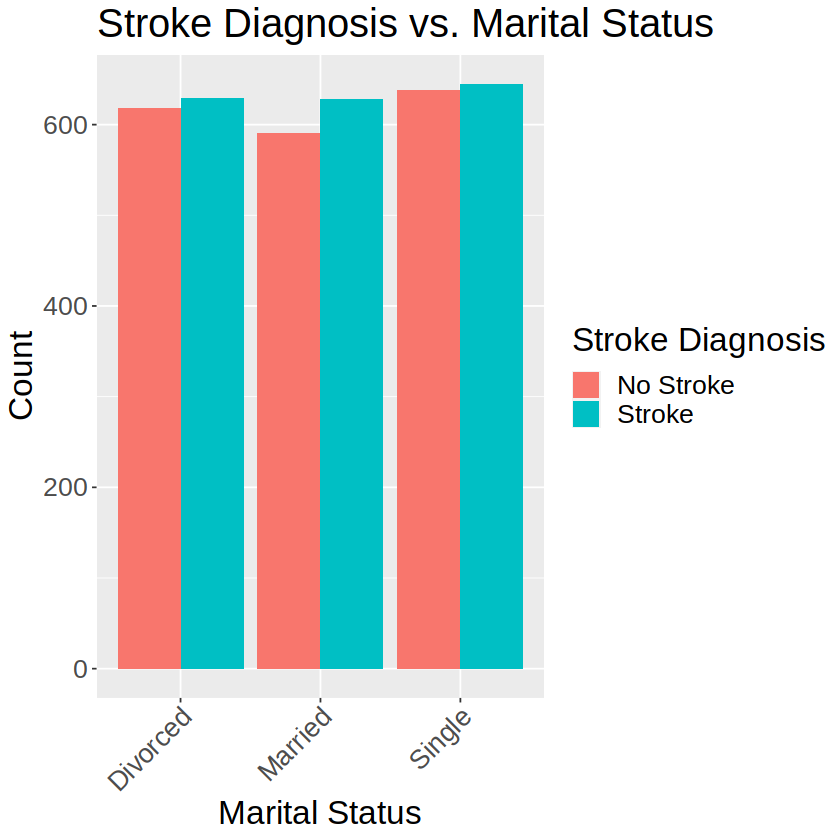

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


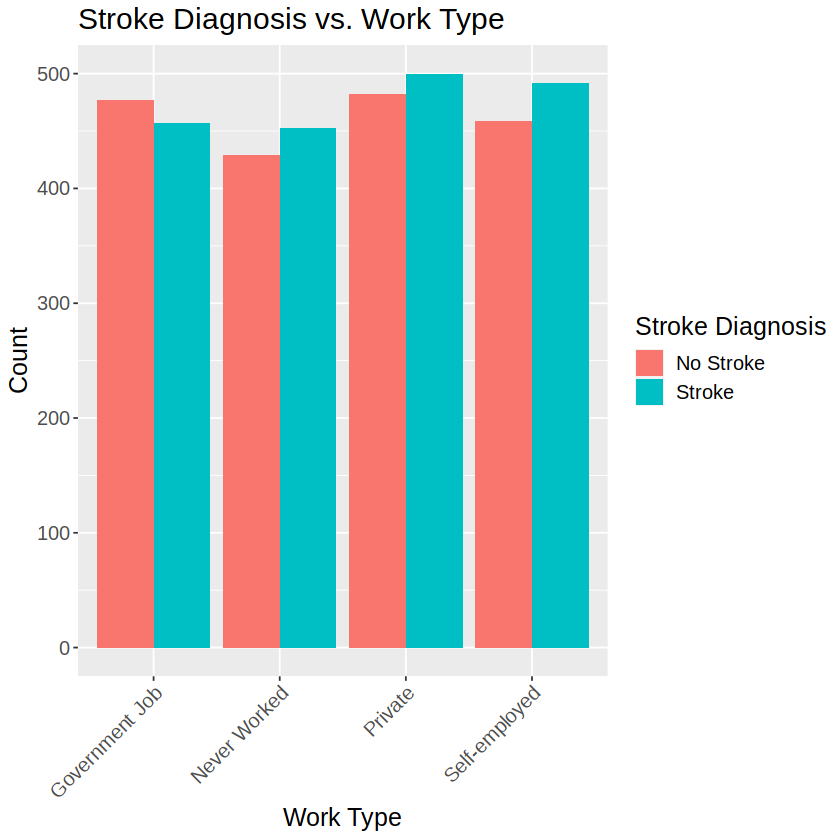

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


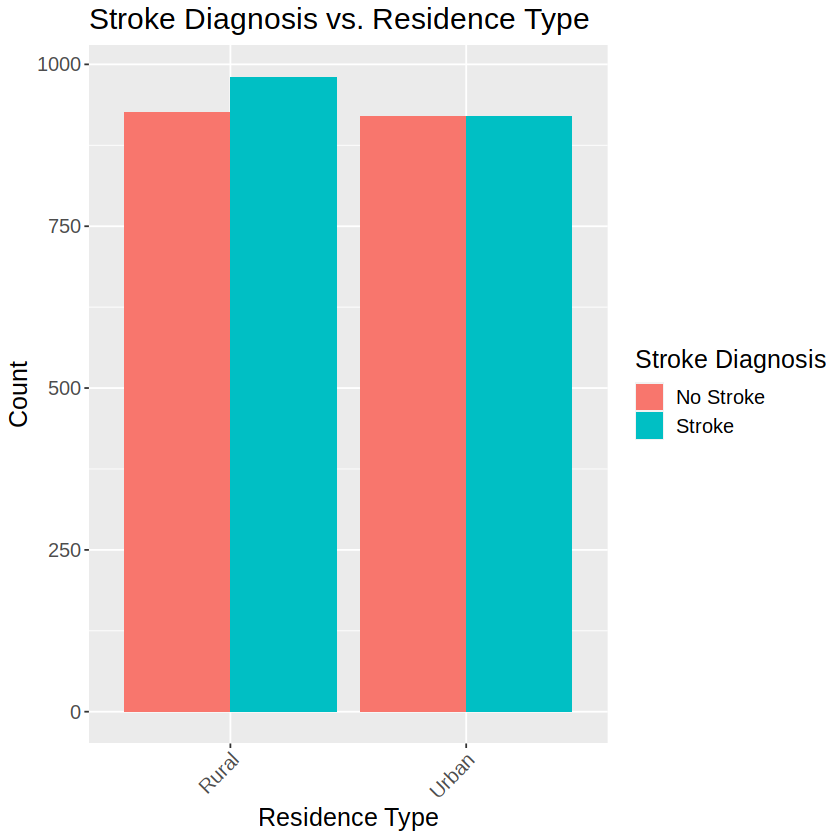

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


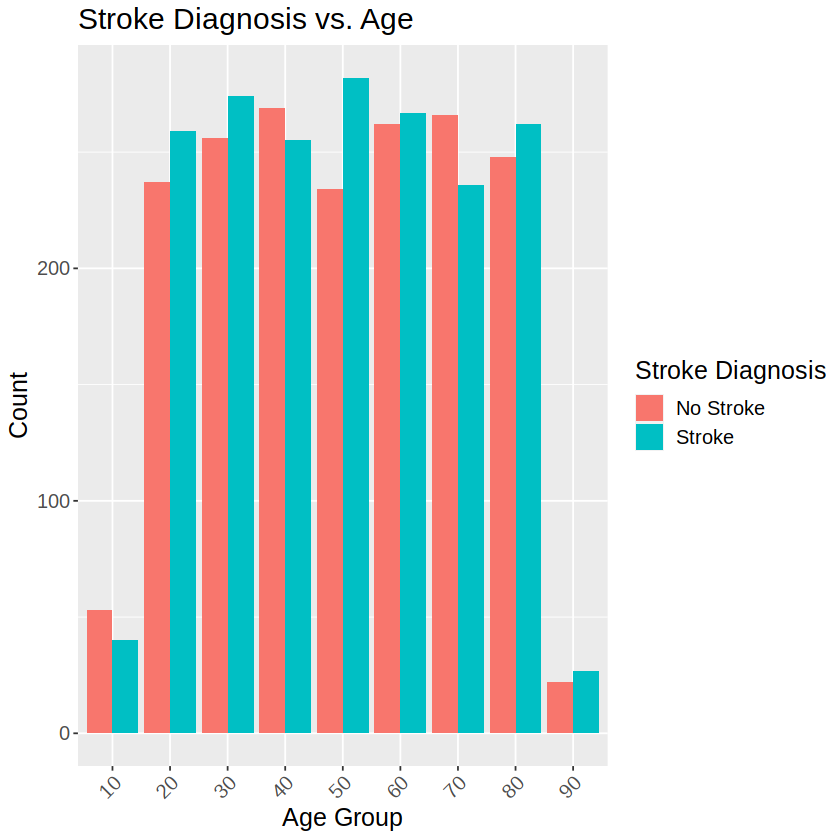

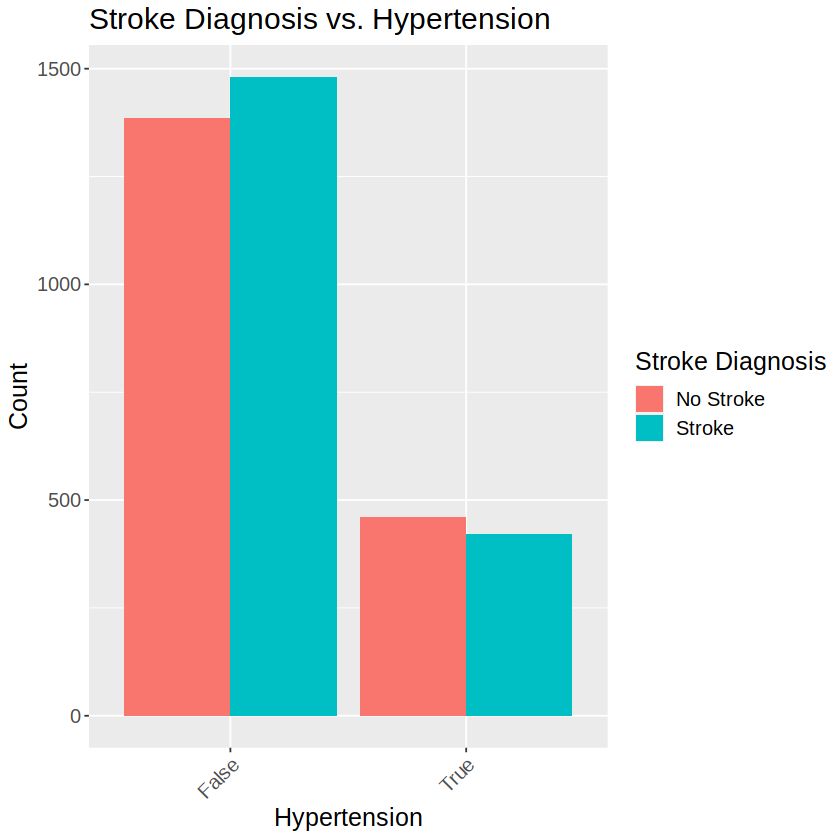

In [44]:
options(repr.plot.width = 7, repr.plot.height = 7)

stroke_marital <- stroke_training |>
            ggplot(aes(x = marital_status, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Marital Status", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Marital Status") +
            theme(text = element_text(size = 20)) +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_marital


stroke_work <- stroke_training |>
            ggplot(aes(x = work_type, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Work Type", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Work Type") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_work

stroke_residence <- stroke_training |>
            ggplot(aes(x = residence_type, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Residence Type", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Residence Type") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_residence

stroke_age <- stroke_training |>
            ggplot(aes(x = age_group, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Age Group", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Age") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_age

stroke_hyper <- stroke_training |>
            ggplot(aes(x = hypertension, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Hypertension", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Hypertension") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_hyper

Warning message in geom_histogram(stat = "count", position = "dodge"):
“Ignoring unknown parameters: `binwidth`, `bins`, and `pad`”


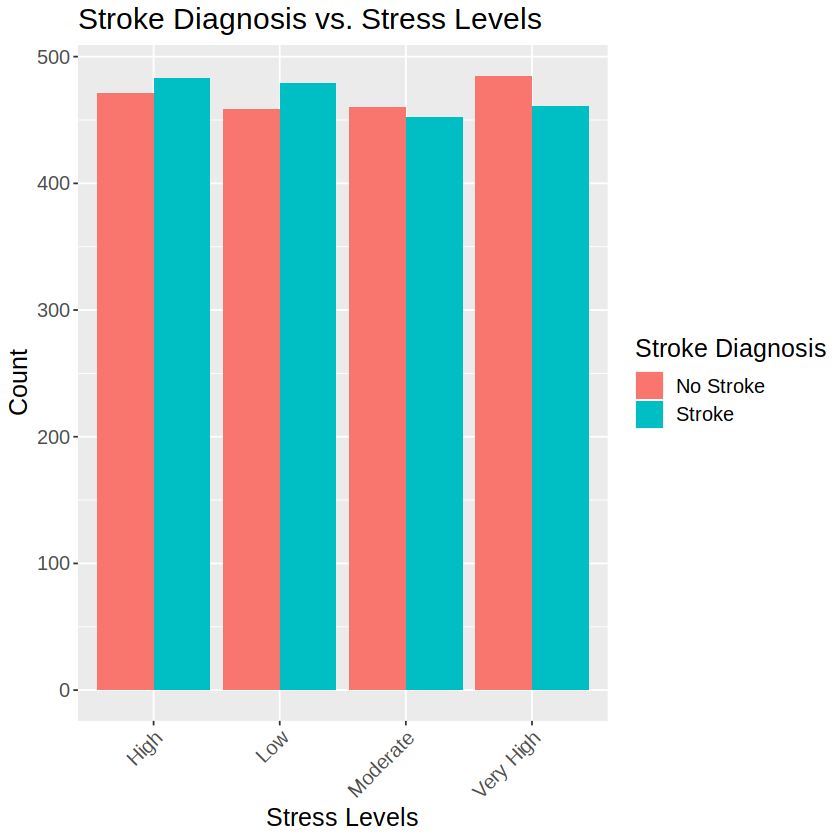

In [11]:
stroke_stress <- stroke_training |>
            ggplot(aes(x = stress_level_category, fill = diagnosis)) +
            geom_histogram(stat = "count", position = "dodge") +
            labs(x = "Stress Levels", y = "Count", fill = "Stroke Diagnosis") +
            ggtitle("Stroke Diagnosis vs. Stress Levels") +
            theme(text = element_text(size = 15))  +
            theme(axis.text.x = element_text(angle = 45, hjust = 1))
stroke_stress

Methods:
Our dataset contains 19 predictors for stroke probability. We will use age, stress levels, hypertension, marital status, and residence type for prediction. We think all of these variables will be useful for prediction as from outside research, blood pressure levels (hence hypertension), stress levels, and age are causes of strokes. Variables such as marital status and residence type also can affect these variables, and seem to have a tangible difference for diagnosis as seen from the bar plots. Since we are using multiple predictors, we have no way to visualize it on a 2D plane.

Expected outcomes and significance:
We expect to find correlation between some of theses variables, and that all the variables play a big part in predicting strokes. Some of these variables lead to outside factors such as economic status and mental wellbeing, etc. If we can accurately predict strokes based on these variables, it can prove the connection between personal wellbeing and strokes, which can influence policies aimed for health. This can also lead to future questions such as to what extent is there correlation between these variables and others outside the scope of our project, and how could that influence the prediction of strokes.